# Flop Holdem Poker - CFR Algorithm

## Objective and Import

In [4]:
#Like Texas Holdem but only two betting rounds, 3 community cards) (First do for only pair, then others combinaisons) (With single choice of bet) (Two pocket cards)
#Objective : Handle large number of combinaison through CFR+ (Avg strat, Pruning, Alternate regret)

In [5]:
#%pip install tqdm
#%pip install networkx
#%pip install alive_progress

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle, seed
import time
import sys
import networkx as nx #Pour créer visuel de réseaux de neurones
from scipy.special import comb #comb = coefficient binomial
from tqdm import tqdm #Pour créer barre de progression
import json #Pour enregistrer le dictionnaire des strategies dans un fichier JSON
from joblib import Parallel, delayed #Pour calculer sur plusieurs CPU en parallèle


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os

# Nombre de cœurs CPU disponibles
print(os.cpu_count())

2


In [9]:
import pickle


## Flop Holdem Class

In [10]:
from sre_constants import CATEGORY_LOC_WORD
class FlopHoldemGame:
    def __init__(self):
        '''Constructeur Self'''
        #h = heart, d = diamond, s = spade, c = club

        #Kunh Poker
        #self.deck = ["Jh", "Qh", "Kh"]
        #self.num_bets = 1
        #self.num_pocket_cards = 1 #Mettre entre parallèle le code pour le cas num_pocket_cards = 1 pour optimiser code
        #self.num_common_cards = 0
        #self.num_actions = 2
        #Nombre de noeud théorique : 12
        #Record battu : 12
        #Nombre d'updates enregistrés : 1 000 000
        #Temps total d'apprentissage : 21 secondes (Essaie 1)
        #ETAT VALIDE

        #Le Duc Poker
        #self.deck = ["Jh", "Jc", "Qh", "Qc", "Kh", "Kc"]
        #self.num_bets = 2
        #self.num_pocket_cards = 1
        #self.num_common_cards = 1
        #self.num_actions = 2
        #Nombre de noeud théorique : 264
        #Record battu : 264
        #Nombre d'updates enregistrés : 1 000 000
        #Temps total d'apprentissage records: 212 secondes (Essaie 1) 96 secondes (Essaie 2)
        #ETAT VALIDE

        #Flop Holdem Poker
        self.deck = np.array(["Xh", "Jh", "Qh", "Kh", "Ah",
                              "Xd", "Jd", "Qd", "Kd", "Ad",
                              "Xs", "Js", "Qs", "Ks", "As",
                              "Xc", "Jc", "Qc", "Kc", "Ac"]) #Normal, Flop Holdem Poker avec 52 cartes
        self.num_bets = 2
        self.num_pocket_cards = 2
        self.num_common_cards = 3 #Corriger problème pour num_common_cards >= 4
        self.num_actions = 2
        #Nombre de noeud théorique : 1241080
        #Record battu : 1062934
        #Nombre d'updates enregistrés : 1 000 000
        #Temps total d'apprentissage records = 9 min 3 (Essaie 1)
        #ETAT EN COURS

        #Royal Holdem Poker
        #self.deck = np.array(["Xh", "Jh", "Qh", "Kh", "Ah",
        #                      "Xd", "Jd", "Qd", "Kd", "Ad",
        #                      "Xs", "Js", "Qs", "Ks", "As",
        #                      "Xc", "Jc", "Qc", "Kc", "Ac"])
        #self.num_bets = 4
        #self.num_pocket_cards = 2
        #self.num_common_cards = 5 #On considère seulement les cartes qui génèrent les meilleurs combinaisons avec la main
        #self.num_actions = 2 #Puis +
        #Nombre de noeud théorique :
        #Record battu :
        #Nombre d'updates enregistrés :
        #Temps total d'apprentissage :
        #ETAT EN ATTENTE D'ETAPE PRECEDENTE

        #Texas Holdem Head's Up - Limited
        #self.deck = np.array(["2h", "3h", "4h", "5h", "6h", "7h", "8h", "9h", "Xh", "Jh", "Qh", "Kh", "Ah",
        #                      "2d", "3d", "4d", "5d", "6d", "7d", "8d", "9d", "Xd", "Jd", "Qd", "Kd", "Ad",
        #                      "2s", "3s", "4s", "5s", "6s", "7s", "8s", "9s", "Xs", "Js", "Qs", "Ks", "As",
        #                      "2c", "3c", "4c", "5c", "6c", "7c", "8c", "9c", "Xc", "Jc", "Qc", "Kc", "Ac"])
        #self.num_bets = 4
        #self.num_pocket_cards = 2
        #self.num_common_cards = 5 #On considère seulement les cartes qui génèrent les meilleurs combinaisons avec la main
        #self.num_actions = 4
        #Nombre de noeud théorique :
        #Record battu :
        #Nombre d'updates enregistrés :
        #Temps total d'apprentissage :
        #ETAT EN ATTENTE D'ETAPE PRECEDENTE

        self.expected_game_value = 0 #Espérance de gain de jeu
        self.num_cards = len(self.deck) #Nombre de cartes
        self.num_players = 2 #Nombre de joueur
        self.betting_round = 1 #Indice de la manche en cours  #A enlever du self #A mettre dans le node
        self.final_score = 0 #Indice du score final (1 = P1 gagne, -1 = P2 gagne, 0 = Egalité) #A enlever du self
        self.common_cards = ""  #A enlever du self
        self.players_cards = ["" for i in range(self.num_players)] #A enlever du self
        self.actions_dict = {0: 'p', 1: 'b'}

        #FAIRE MULTIPROCESSING : https://www.youtube.com/watch?v=X7vBbelRXn0

        #Hyper-paramètre - Learning Performance
        #self.regret_threshold = 0.25
        self.epsilon = 0.001
        self.start_threshold = 30 #Minimum pour appliquer le Test de Convergence de Cauchy #Car en statistique on prend n=30 minimum pour appliquer théorême Central Limite
        self.regret_threshold = 0
        self.PReLU_coeff = 0

        #Memory of learning into Strategy Dictionnary
        self.num_played_games = 0
        self.nodeMap = {}
        self.num_visited_nodes = 0
        self.num_theorical_nodes = 0
        self.num_converged_nodes = 0
        self.edges_list = []
        self.playable_nodes = []
        self.stratDict = {} #Strategy on the Nash Equilibriul
        self.isGameConverged = False

        #Analysis of execution time parameters
        self.trainingTime = []
        self.executionTime = 0 #Temps d'execution d'entrainement pour un même objet FlopHoldemGame
        self.totalTrainingTime = 0 #Temps d'execution d'entrainement dont le temps d'apprentissage du modèle pré-entrainé

        #Hyper Paramètre - Option CFR +
        self.weight_average_strategy = True
        self.alternate_player_updates = False
        self.with_deepCfr = True #Pruning
        #Do with ReBel

        #Deep CFR
        self.deepCfr_from_pretrained = DeepCfr(self.deck, self.num_cards, self.num_common_cards, self.num_pocket_cards, self.num_actions, self.num_bets)

    def game(self):
        '''Fonction executant le jeu d'une partie de poker'''
        self.init_cfr() #Initialisation de la Partie
        self.final_score = self.compareSet() ##Calcul résultat final
        self.expected_game_value += self.cfr("", 1, 1) #Lancement Algo CFR

        #Fin de partie / On rend les cartes
        self.common_cards = ""
        self.players_cards = ["" for i in range(self.num_players)]
        self.trainingTime.append(time.time())
        return


    def import_trained_dataset(self, path_trained_dataset, clean_dataset):
        '''Initialisation l'entrainement du modèle (Dont en important le modèle déjà entrainé)'''
        try:
            if (clean_dataset):
                with open(path_trained_dataset, 'w') as json_file:
                    json.dump({}, json_file)
                print("Le fichier JSON situé à l'emplacement {} a été nettoyé.".format(path_trained_dataset))
            else:
                print("Import Trained Dataset...")
            with open(path_trained_dataset, 'r') as json_file:
                self.stratDict = json.load(json_file)
        except Exception as e:
            print("Une erreur est survenue:", str(e))
            print("Création JSON file au :",path_trained_dataset)
        else:
            if (len(self.stratDict) != 0):
                self.num_theorical_nodes = self.stratDict['Number of Theorical States']
                self.num_visited_nodes = self.stratDict['Number of Visited States']
                self.num_played_games = self.stratDict['Number of Played Games']
                self.num_converged_nodes = self.stratDict['Number of Converged States']
                self.totalTrainingTime = self.stratDict['Total Training Time']
                self.isGameConverged = self.stratDict['Is Game Converged']

                print()
                print("Dataset :")
                print("Nombre Etats Théoriques : {}".format(self.num_theorical_nodes))
                print("Nombre Etats Déjà Atteints : {}".format(self.num_visited_nodes))
                print("Nombre Etats Convergés : {}".format(self.num_converged_nodes))
                print("Nombre de parties jouées : {}".format(self.num_played_games))
                print("Temps d'apprentissage des données pré-entrainé : {} minutes".format(self.totalTrainingTime/60))
                print()
        #shuffle(self.deck)
        return

    def init_cfr(self):
        '''Initiatisation des données d'une partie de poker'''

        self.betting_round = 1
        if(self.num_theorical_nodes != 0):
            self.regret_threshold = self.num_converged_nodes/self.num_theorical_nodes

        #self.start_threshold = 30 #Minimum pour établir le théorême central limite

        #Melange du deck
        shuffle(self.deck)

        #Distribution des cartes
        #Pocket Cards P1
        for i in range(self.num_players):
            start_index_1 = i * self.num_pocket_cards
            for j in range(self.num_pocket_cards):
                self.players_cards[i] = self.players_cards[i] + self.deck[start_index_1+j]
            self.players_cards[i] = sort_cards(self.players_cards[i])

        #Flop
        start_index_2 = self.num_players * self.num_pocket_cards
        for i in range(self.num_common_cards):
            if start_index_2 + i <= self.num_cards:
                self.common_cards = self.common_cards + self.deck[start_index_2 + i]
        self.common_cards = sort_cards(self.common_cards)
        return

    def train(self, path_dataset, n_iterations=1000, clean_dataset=False):
        '''Entraine le modèle en utilisant l'algo CFR'''

        time_start = time.time()
        self.trainingTime = []
        self.trainingTime.append(time_start)

        self.import_trained_dataset(path_trained_dataset, clean_dataset) #Importation du dataset pré-entrainé
        self.init_graph()

        print("Start Training :")

        #pbar = tqdm(total=100) #Barre de progression 1
        #previous_percentage = 0
        #current_percentage = (iter / n_iterations) * 100
        #if (int (current_percentage) != previous_percentage):
            #    pbar.update(int(current_percentage) - previous_percentage)
            #    previous_percentage = int(current_percentage)

        #Ou #for iter in tqdm(range(1, n_iterations +1)):
        #Ou with alive_bar(len(items)) as bar:
        #        for ...
        #        bar()

        #seed(42) #Génération d'une seed connue pour analyser des résultats connues

        #Problème pour actualiser des instances self dans le delayed
        #self.trainingTime = self.trainingTime + Parallel(n_jobs=-1)(
        #    delayed(self.game)() for iter in tqdm(range(1, n_iterations+1))
        #)
        #self.trainingTime.sort()

        for iter in tqdm(range(1, n_iterations+1)):
            if self.num_converged_nodes != self.num_theorical_nodes:
                self.game()

        for i in range(n_iterations, 0, -1):
            self.trainingTime[i] = self.trainingTime[i] - self.trainingTime[i-1]
        self.trainingTime[0] = 0
        trainingTime = abs(time.time() - time_start)
        self.executionTime += trainingTime #Temps d'execution d'entrainement pour un même objet FlopHoldemGame
        self.totalTrainingTime += trainingTime #Temps d'execution d'entrainement dont le temps d'apprentissage du modèle pré-entrainé

        #pbar.close()
        print("Save Training Dataset :")

        self.num_played_games += n_iterations
        self.expected_game_value /= n_iterations
        if self.num_converged_nodes == self.num_theorical_nodes:
            self.isGameConverged = True
        self.set_StrategyModel()

        display_results(self.expected_game_value, self.nodeMap, self.executionTime, self.totalTrainingTime, self.num_theorical_nodes, self.num_visited_nodes, self.num_converged_nodes, self.num_played_games, self.isGameConverged)
        print(self.edges_list)
        print(self.playable_nodes)
        #get_unitaryNodeMap(self.edges_list, self.nodes_playable) #A print en dehors du training
        #if(len(self.stratDict) <= 100):
        #    print(self.get_StrategyModel())
        return

    def cfr(self, history, pr_1, pr_2):

        assert len(history) < self.num_bets * 4
        '''Algorithme CFR'''
        #History = Sequence of action until the node considered
        #pr_1 = Probability from player 1 to get to this node
        #pr_2 = Probability from player 2 to get to this node

        if ('r' not in history):
            self.betting_round = 1
        is_P1 = True
        if (self.betting_round == 1):
            is_P1 = (len(history) % 2 == 0)
        else:
            is_P1 = (list(reversed(list(history))).index('r') % 2 == 0)

        if self.is_terminal(history):
            return self.get_reward(history, is_P1)

        player_cards = self.players_cards[0] if is_P1 else self.players_cards[1] #A modif dans le cadre de plusieurs joueurs
        if ('r' in history):
            player_cards = player_cards + self.common_cards #Prendre les 5 cartes qui ont la meilleur combinaison

        node = self.get_node(player_cards, history, is_P1)
        strategy = node.strategy
        action_utils = np.zeros(self.num_actions) # Counterfactual utility per action #Gain par action

        for act in range(self.num_actions):
            next_history = history + node.action_dict[act]
            if (next_history[-2:] == "bb") and (self.betting_round != self.num_bets):
                #Card reveal
                #We have reached the end of a betting turn
                next_history = next_history + "r"
                self.betting_round += 1

            #Pruning - We deep dive into the graph for regret above a certain limit (On peut aussi prendre (iter/self.n_iteration)**2 )
            # and node.num_updates >= self.start_threshold
            if node.isConverged and (strategy[act] < self.regret_threshold) and self.with_deepCfr:
                action_utils[act] = node.get_prediction_reward(self.final_score)
            else:
                # -1 pour se placer du point de vue de l'autre joueur à chaque progression dans l'arbre du jeu
                if is_P1:
                    action_utils[act] = -1 * self.cfr(next_history, pr_1 * strategy[act], pr_2)
                else:
                    action_utils[act] = -1 * self.cfr(next_history, pr_1, pr_2 * strategy[act])

        #Utility of information set
        util = sum(action_utils * strategy)

        #Check coherence error
        #if (history == X):
        #    opponent_card = self.deck[1] if is_P1 else self.deck[0]
        #    print("IS P1 : {}".format(is_P1))
        #    print("History : {}".format(history))
        #    print("Actions_utils : {}".format(action_utils))
        #    print("Regrets = {}".format(regrets))
        #    print("Player Card : {}".format(player_cards))
        #    print("Opponent Card : {}".format(opponent_card))

        if not node.isConverged:
            regrets = action_utils - util
            if is_P1:
                node.reach_pr += pr_1
                node.regret_sum += pr_2 * regrets
            else:
                node.reach_pr += pr_2
                node.regret_sum += pr_1 * regrets

            #if (self.alternate_player_updates) and (is_P1() == (iter % 2 == 0)): #CFR+ - Alternate between players
            self.num_converged_nodes += node.update_node(util, self.final_score, self.weight_average_strategy)

        return util

    def is_terminal(self, history):
        '''Valide si le noeud correspond est un noeud final'''
        isTerminal = False
        isTerminal = isTerminal or (history[-2:] == "pp")
        isTerminal = isTerminal or (history[-2:] == "bp")
        isTerminal = isTerminal or ((history[-2:] == "bb") and (self.betting_round == self.num_bets))
        return isTerminal

    def get_reward(self, history, is_player_1):
        '''Renvoie la recompense associée à l'historique du jeu'''
        terminal_pass = (history[-1] == 'p')
        terminal_bet = (history[-2:] == 'bb')
        bet = self.betting_round
        if terminal_pass:
            if history[-2] == 'pp':
                if (self.final_score == 0):
                    return 0
                if (is_player_1):
                    if (self.final_score == 1):
                        return bet
                    else:
                        return -bet
                else :
                    if (self.final_score == -1):
                        return bet
                    else :
                        return -bet
            else:
                return bet
        elif terminal_bet:
            if (self.final_score == 0):
                    return 0
            bet += 1
            if (is_player_1):
                if (self.final_score == 1):
                    return bet
                else:
                    return -bet
            else :
                if (self.final_score == -1):
                    return bet
                else :
                    return -bet
        return(-100)

    def compareSet(self):
        '''Renvoie (1) si le joueur 1 gagne sur son opposant, (0) si il y a égalité, (-1) s'il perd '''
        hand_P1 = self.players_cards[0]
        hand_P2 = self.players_cards[1]
        score_1, details_1 = handValue(hand_P1 + self.common_cards)
        score_2, details_2 = handValue(hand_P2 + self.common_cards)
        if (score_1 > score_2):
            return 1
        elif (score_1 == score_2):
            for i in range(len(details_1)):
                if(details_1[i] > details_2[i]):
                    return 1
                elif(details_1[i] < details_2[i]):
                    return -1
            return 0
        return -1

    def getBet(self, bet):
        '''Renvoie le gain positif de la partie'''
        if (self.final_score == 0):
            return 0
        return bet

    def get_node(self, cards, history, is_P1):
        '''Renvoie le noeud correspondant suivant l'historique de jeu'''
        key = str(cards) + " " + history
        if key not in self.nodeMap:
            strategy = np.repeat(1/self.num_actions, self.num_actions)
            num_updates, num_victories, num_defeats  = 0, 0, 0
            average_reward, average_reward_won, average_reward_lost = 0, 0, 0
            isConverged = False
            try:
                strategy, num_updates, num_victories, num_defeats, average_reward, average_reward_won, average_reward_lost, isConverged = self.get_infoset(cards, history)
            except Exception as e:
                #print("Exception relevé : " + str(e))
                self.num_visited_nodes += 1

            infoset = Node(key, self.actions_dict, is_P1, strategy, num_updates, num_victories, num_defeats, average_reward, average_reward_won, average_reward_lost, isConverged, self.epsilon, self.start_threshold, self.PReLU_coeff)
            self.nodeMap[key] = infoset
            return infoset
        return self.nodeMap[key]

    def get_nodeMap(self):
        '''Renvoie le nodeMap'''
        return self.nodeMap

    def set_StrategyModel(self):
        '''Créer / Actualise le dictionnaire de strategie du modèle'''
        self.stratDict['Number of Played Games'] = self.num_played_games
        self.stratDict['Number of Theorical States'] = self.num_theorical_nodes
        self.stratDict['Number of Visited States'] = self.num_visited_nodes
        self.stratDict['Total Training Time'] = self.totalTrainingTime
        self.stratDict['Number of Converged States'] = self.num_converged_nodes
        self.stratDict['Is Game Converged'] = self.isGameConverged

        nodeMapItems = self.nodeMap.items()
        #with alive_bar(len(nodeMapItems)) as bar:
        for key, node in tqdm(nodeMapItems):
            keys = key.split()
            cards, actions = "", ""
            if(len(keys) == 2):
                cards, actions = keys[0], keys[1]
            else:
                cards = keys[0]
            chemin = []
            for i in range(0, len(cards), 2):
                chemin.append(cards[i:i+2])
            chemin.append("act")
            chemin = chemin + list(actions)
            chemin.append("strat")
            self.add_StrategyBranch(self.stratDict, chemin, node.average_strategy, node.num_updates, node.num_victories, node.num_defeats, node.average_reward, node.average_reward_won, node.average_reward_lost, node.isConverged)

            #On actualise la barre de progression
            #bar()
        return

    def add_StrategyBranch(self, noeud, chemin, strategy, num_updates, num_victories, num_defeats, average_reward, average_reward_won, average_reward_lost, convergence_state, profondeur = 0):
        """Ajouter une branche à l'arbre à une position spécifiée par chemin"""
        if profondeur == len(chemin):
            noeud["val"] = list(np.around(strategy, 4))
            noeud["nu"] = num_updates
            noeud["nv"] = num_victories
            noeud["nd"] = num_defeats
            noeud["ar"] = round(average_reward, 3)
            noeud["arw"] = round(average_reward_won, 3)
            noeud["arl"] = round(average_reward_lost, 3)
            noeud["cs"] = 1 if convergence_state else 0
            return
        if chemin[profondeur] not in noeud.keys():
            noeud[chemin[profondeur]] = {}
        return self.add_StrategyBranch(noeud[chemin[profondeur]], chemin, strategy, num_updates, num_victories, num_defeats, average_reward, average_reward_won, average_reward_lost, convergence_state, profondeur + 1)

    def get_StrategyModel(self):
        '''Renvoie le dictionnaire des stratégies entrainées par le modèle'''
        return self.stratDict

    def get_infoset(self, cards, actions):
        '''Renvoie la strategie pré-entrainé suivant les cartes et les actions données'''
        stratDict = self.stratDict

        #Mise en forme des cartes et actions
        cardsList, actionsList = [], list(actions)
        n = len(cards)
        for i in range(0, n, 2):
            cardsList.append(cards[i:i+2])

        #Parcours du graphe du modèle de stategy
        for card in cardsList:
            stratDict = stratDict[card]
        stratDict = stratDict["act"]
        for action in actionsList:
            stratDict = stratDict[action]
        strategy = stratDict["strat"]
        return strategy["val"], strategy["nu"], strategy["nv"], strategy["nd"], strategy["ar"], strategy["arw"], strategy["arl"], strategy["cs"]

    def get_trainingEvolution(self):
        '''Affiche le graphique de l'évolution des temps d'execution par iteration'''
        n = len(self.trainingTime)
        trainingTime = np.log(np.array([self.trainingTime[i] for i in range(n) if self.trainingTime[i] != 0]))
        x = np.arange(len(trainingTime))
        window_size = 100
        trainingTimeSmooth = np.convolve(trainingTime, np.ones(window_size)/window_size, mode='valid')
        xSmooth = np.arange(len(trainingTimeSmooth))
        window_size_plus = 10000
        trainingTimeSmoothPlus = np.convolve(trainingTime, np.ones(window_size_plus)/window_size_plus, mode='valid')
        xSmoothPlus = np.arange(len(trainingTimeSmoothPlus))
        plt.figure(figsize=(10, 6))
        plt.plot(x, trainingTime, label="Données originales")
        plt.plot(xSmooth, trainingTimeSmooth, label="Données moyennées selon 100", linewidth=3)
        plt.plot(xSmoothPlus, trainingTimeSmoothPlus, label="Données moyennées selon 10000", linewidth=2, color='r')
        #plt.ylim(top=0.0003)
        plt.title("Evolution des temps de calculs par iteration d'entrainement")
        plt.xlabel("Nombre d'itérations")
        plt.ylabel("Log(Temps) (s)")
        plt.legend()
        plt.show()
        return

    def get_exectionTime(self):
        '''Renvoie le temps d'execution de l'entrainement'''
        return self.executionTime

    def get_num_node_theorique(self):
        '''Renvoie le nombre de noeud théorique pour le jeu de poker donnée'''
        # = Nombre de combinaison possible main parmi toutes les cartes de pocket_cards et pockets_cards + common_cards parmi toutes les cards
        # * Nombre d'histoires possibles qui n'est pas une terminaison
        num_nodes = 0
        num_possible_hands = comb(self.num_cards, self.num_pocket_cards, exact=True)
        num_possible_flop = comb(self.num_cards - self.num_pocket_cards, min(self.num_common_cards, 3), exact=True)
        num_possible_turn = comb(self.num_cards - self.num_pocket_cards, 4, exact=True)
        num_possible_river = comb(self.num_cards - self.num_pocket_cards, 5, exact=True)
        for node in self.playable_nodes:
            num_occurence_r = node.count('r')
            if num_occurence_r == 0:
                num_nodes += num_possible_hands
            if num_occurence_r == 1:
                num_nodes += num_possible_hands*num_possible_flop
            if num_occurence_r == 2:
                num_nodes += num_possible_hands*num_possible_turn
            if num_occurence_r == 3:
                num_nodes += num_possible_hands*num_possible_river
        return num_nodes

    def init_graph(self):

        #On calcule déjà le graph en sous-jeu
        self.set_edges_list("")

        #On determine les noeuds où il est possible d'établir un stratégie
        playable_nodes = []
        n = len(self.edges_list)
        for i in range(n):
            key = self.edges_list[i][0]
            next = self.edges_list[i][1]
            if (key not in playable_nodes) and (next[-1] != 'r'):
                playable_nodes.append(key)
        self.playable_nodes = playable_nodes

        #On calcule le nombre de noeuds theorique total
        self.num_theorical_nodes = self.get_num_node_theorique()

        #On réinitialise betting_roud à 1 pour la suite de l'algo
        self.betting_round = 1
        return

    def set_edges_list(self, history):
        '''Construit les arêtes du graph et les places dans la liste edges_list'''
        #Fonction récursive
        if ('r' not in history):
            self.betting_round = 1

        if self.is_terminal(history):
            return

        for act in range(self.num_actions):
            next_history = history + self.actions_dict[act]
            edge = (history, next_history)
            if edge not in self.edges_list:
                self.edges_list.append(edge)
            if (next_history[-2:] == "bb") and (self.betting_round != self.num_bets):
                save_history = next_history
                next_history = next_history + "r"
                random_edge = (save_history, next_history)
                self.betting_round += 1
                if random_edge not in self.edges_list:
                    self.edges_list.append(random_edge)

            self.set_edges_list(next_history)
        return

    def get_subgame(self):
        '''Renvoie la liste des noeuds d'un sous-jeu de poker'''
        return self.edges_list, self.playable_nodes


## Node Class

In [11]:
class Node:
    def __init__(self, key, action_dict, is_P1, strategy, num_updates, num_victories, num_defeats, average_reward, average_reward_won, average_reward_lost, isConverged, epsilon, start_threshold, PReLU_coeff):
        self.key = key
        self.n_actions = len(action_dict.keys())
        self.is_P1 = is_P1
        self.isConverged = isConverged #Test de Cauchy pour tester la convergence
        #Tolérance sur l'amélioration, on s'arrete d'améliorer les strategies si abs(strat_n+1 - strat_n) < epsilon

        #Hyper-Paramètre
        self.epsilon = epsilon
        self.start_threshold = start_threshold
        self.PReLU_coeff = PReLU_coeff

        self.strategy = np.array(strategy)
        self.average_strategy = np.array(strategy)
        self.num_updates = num_updates
        self.num_victories = num_victories
        self.num_defeats = num_defeats
        self.average_reward = average_reward
        self.average_reward_won = average_reward_won
        self.average_reward_lost = average_reward_lost

        #Possible action
        self.action_dict = action_dict
        #Probability of each possible action in a node


        #Probability of reaching this node on the game tree
        self.reach_pr = 0
        self.reach_pr_sum = 0

        #Sum of difference between counter factual reward and actual reward
        self.regret_sum = np.zeros(self.n_actions)
        self.strategy_sum = np.zeros(self.n_actions)

        #self.num_updates_average_reward = 0

    def get_prediction_reward(self, final_score):
        #print("INTO PRUNING")
        #print("Key : {}".format(self.key))
        #print("Average Reward : {}".format(self.average_reward))
        #print("Num Updates : {}".format(self.num_updates_average_reward))
        #print("Strategy : {}".format(self.strategy))
        if(final_score == 1):
            if(self.is_P1):
                return self.average_reward_won
            else:
                return self.average_reward_lost
        elif(final_score == -1):
            if(self.is_P1):
                return self.average_reward_lost
            else:
                return self.average_reward_won
        return 0

    def update_node(self, reward, final_score, weight_average_strategy):
        '''Actualise la stratégie, les recompensés moyennes et les taux de victoire du noeud joué dans la partie'''
        #Formule basé sur la suite récurrente des moyennes empiriques
        self.num_updates += 1
        self.average_reward = (self.num_updates * self.average_reward + reward) / (self.num_updates + 1) #Utile pour étudier la distribution statistique des récompences avec les trois moyennes empiriques

        if(final_score == 1):
            if(self.is_P1):
                self.num_victories += 1
                self.average_reward_won = (self.num_victories * self.average_reward_won + reward) / (self.num_victories + 1)
            else:
                self.num_defeats += 1
                self.average_reward_lost = (self.num_defeats * self.average_reward_lost + reward) / (self.num_defeats + 1)

        elif(final_score == -1):
            if(self.is_P1):
                self.num_defeats += 1
                self.average_reward_lost = (self.num_defeats * self.average_reward_lost + reward) / (self.num_defeats + 1)
            else:
                self.num_victories += 1
                self.average_reward_won = (self.num_victories * self.average_reward_won + reward) / (self.num_victories + 1)

        #On sauvegarde les précédents valeurs pour tester si le noeud a convergé
        previous_reach_pr_sum = self.reach_pr_sum
        previous_strategy_sum = self.strategy_sum

        self.strategy = self.get_strategy() #A REVOIR POURQUOI ICI
        if (weight_average_strategy):
            #When computing average strategy, we weigh iteration t by t #CFR +
            self.reach_pr_sum += self.num_updates * self.reach_pr
            self.strategy_sum += self.num_updates * self.reach_pr * self.strategy
        else:
            self.reach_pr_sum += self.reach_pr
            self.strategy_sum += self.reach_pr * self.strategy
        self.reach_pr = 0 #A ETUDIER INFLUENCE

        self.average_strategy = self.get_average_strategy()

        if(self.num_updates >= self.start_threshold):
            previous_average_strategy = previous_strategy_sum / previous_reach_pr_sum
            previous_average_strategy /= sum(previous_average_strategy)
            if (np.all(np.abs(self.average_strategy - previous_average_strategy) < self.epsilon)):
                self.isConverged = True
                return 1

        return 0

    def get_strategy(self):
        regrets = self.regret_sum
        #Resolve problem with strategy = [x, 0] which influence pr_1 for action = 'pb'
        #Exactement comme fonction d'activation ReLU
        #Utiliser PReLU = Parametric Rectified Linear Unit
        regrets[regrets < 0] = 0 #After each iteration, if regret < 0, set regret = 0 #CFR +
        normalizing_sum = sum(regrets)
        if normalizing_sum != 0:
            return regrets / normalizing_sum
        else:
            return self.strategy

    def get_average_strategy(self):
        #When computing weight average strategy weigh iteration t by t #CFR +
        average_strategy = self.strategy

        if self.reach_pr_sum != 0:
            average_strategy = self.strategy_sum / self.reach_pr_sum
            total = sum(average_strategy)
            average_strategy /= total

        return average_strategy

    def get_is_P1(self):
        return self.is_P1

    def get_key(self):
        return self.key

    def __str__(self):
        strategies = ['{:03.2f}'.format(x) for x in self.average_strategy]
        return 'Key : {} | Strategy : {} | Number of Updates : {} | Average Reward : {} | Is Converged : {}'.format(self.key.ljust(30), strategies, self.num_updates, self.average_reward, self.isConverged)

## Display Results


In [12]:
def display_results(ev, i_map, execution_time, total_training_time, num_theorical_nodes, num_visited_nodes, num_converged_nodes, num_played_games, isGameConverged):
    '''Renvoie un champ de texte sortant l'entrainement'''
    print()
    print()
    print('Espérance du joueur 1: {}'.format(ev))
    print('Espérance du joueur 2: {}'.format(-1 * ev))
    print('Nombre total de parties de poker jouées: {}'.format(num_played_games))
    print()
    print("Nombre d\'états théoriques: {}".format(num_theorical_nodes)) #3 723 406 noeuds
    print('Nombre d\'états atteints: {}'.format(num_visited_nodes))
    print('Nombre d\'états convergés: {}'.format(num_converged_nodes))
    print('Jeu Optimal : {}'.format(isGameConverged))

    print()
    print("Temps de calcul entrainement: {} secondes".format(execution_time))
    print("Temps de calcul total avec pré-entrainement: {} secondes".format(total_training_time))
    print()
    #print("Nombre de noeud : {}".format(sys.getsizeof(trainer)))
    return

def display_results_detailed(i_map, min_num_updates = 1, focus_on = ""):
    '''Renvoie un champ de texte sortant les valeurs des stratégies pour chaque combinaisons de cartes et d'actions'''
    n = len(focus_on)
    print()
    print('player 1 strategies:')
    sorted_items = sorted(i_map.items(), key=lambda x: x[0])
    for key, node in filter(lambda x: x[1].get_is_P1(), sorted_items):
        if node.num_updates >= min_num_updates :
          if (n != 0):
              if(key[:n] == focus_on):
                  print(node)
          else:
              print(node)

    print()
    print('player 2 strategies:')
    for key, node in filter(lambda x: not x[1].get_is_P1(), sorted_items):
        if node.num_updates >= min_num_updates:
          if (n != 0):
              if(key[:n] == focus_on):
                  print(node)
          else:
              print(node)
    return


def display_results_detailed_P1_fixed(i_map, min_num_updates):
    '''Renvoie un champ de texte sortant les valeurs des stratégies pour chaque combinaisons de cartes et d'actions'''
    print()
    print('player 1 strategies:')
    sorted_items = sorted(i_map.items(), key=lambda x: x[0])

    is_selected = False
    selected_key = ''
    selected_node = Node('', {0: 'p', 1: 'b'}, True)
    selected_common_cards = []
    for key, node in filter(lambda x: x[1].get_is_P1(), sorted_items):
        if (node.num_updates_strategy >= min_num_updates) and not (is_selected):
            selected_key = key[:4]
            selected_node = node
            is_selected = True

        if (key[:4] == selected_key):
            print(node)
            if(len(key) > 10) and (key[4:10] not in selected_common_cards):
                selected_common_cards.append(key[4:10])

    print("Main du joueur 1")
    print("Key : {} ".format(selected_key))
    print("Common_cards : {}".format(selected_common_cards))

    print()
    print('player 2 strategies:')
    associated_keys_2 = []
    for key, node in filter(lambda x: not x[1].get_is_P1(), sorted_items):
        if (key[4:10] in selected_common_cards):
            associated_keys_2.append(key[:4])

    for key, node in filter(lambda x: not x[1].get_is_P1(), sorted_items):
        if (key[:4] in associated_keys_2):
            print(node)

    return


def get_unitaryNodeMap(edge_list, node_playable):
    '''Renvoie graphe unitaire du jeu de poker'''
    G = nx.DiGraph()
    G.add_edges_from(edge_list)
    pos = nx.planar_layout(G)

    print("Edge List : {}".format(edge_list))
    print("Node Play-able List: {}".format(node_playable))

    # Dessin du graphe
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
    return G


In [13]:
listA = np.array([0.1, 0.9])
listB = np.array([0.15, 0.85])
epsilon = 0.1
A = np.abs(listA - listB) < epsilon
print(A)
print(type(A))

[ True  True]
<class 'numpy.ndarray'>


## Poker Bot / Hand Value Estimator / Test Winning / Sort Cards

In [14]:
def botPoker(cards, actions, strategy_dictionnary):
        '''Renvoie la meilleur strategie suivant les cartes et les actions données'''
        stratDict = strategy_dictionnary

        #Mise en forme des cartes et actions
        cardsList, actionsList = [], list(actions)
        n = len(cards)
        for i in range(0, n, 2):
            cardsList.append(cards[i:i+2])

        #Parcours du graphe du modèle de stategy
        for card in cardsList:
            stratDict = stratDict[card]
        stratDict = stratDict["act"]
        for action in actionsList:
            stratDict = stratDict[action]
        strategy = stratDict["strat"]

        return strategy["val"]

In [15]:
def handValue(cards):
    '''Evalue la force d'une main de poker donnée'''

    #INPUT = cards = "2dXsAhKsAs"
    cartes = []
    for i in range(0, len(cards), 2):
        cartes.append((cards[i], cards[i+1]))

    valeurs = '23456789XJQKA'
    couleur_valeurs = {couleur: index for index, couleur in enumerate('cdhs')}

    #Normalement les cartes sont déjà triées dans le init_cfr(), vaut mieux optimiser les perfs
    cartes_triees = cartes
    #cartes_triees = sorted(cartes, key=lambda x: (valeurs.index(x[0]), couleur_valeurs[x[1]]), reverse = True)

    rangs = ''.join(sorted([c[0] for c in cartes], key=valeurs.index, reverse=True))
    est_flush = (len(set(c[1] for c in cartes)) == 1) and (len(cards) == 5)
    est_straight = ('A2345' in rangs or all(valeurs.index(rangs[i]) - 1 == valeurs.index(rangs[i+1]) for i in range(len(rangs)-1))) and (len(cards) == 5)
    rang_comptes = sorted([rangs.count(r) for r in set(rangs)], reverse=True)
    score_principal = 0
    details = []

    #De la combinaison la plus forte à la plus faible
    if est_flush and est_straight:
        score_principal = 8
    elif rang_comptes == [4, 1]:
        score_principal = 7
    elif rang_comptes == [3, 2]:
        score_principal = 6
    elif est_flush:
        score_principal = 5
    elif est_straight:
        score_principal = 4
    #elif rang_comptes == [3, 1, 1]:
    elif rang_comptes.count(3) == 1:
        score_principal = 3
    #elif rang_comptes == [2, 2, 1]:
    elif rang_comptes.count(2) == 2:
        score_principal = 2
    #elif rang_comptes == [2, 1, 1, 1]:
    elif rang_comptes.count(2) == 1:
        score_principal = 1

    #Construire les détails pour les comparaisons fines
    if score_principal in {1, 2, 3, 7}:
        #Pour les paires, deux paires, brelans et carrés, prioriser les cartes du groupe
        groupes = sorted(((valeur, rangs.count(valeur)) for valeur in set(rangs)), key=lambda x: (x[1], valeurs.index(x[0])), reverse=True)
        details = [valeurs.index(v[0]) for v in groupes] + [valeurs.index(c[0]) for c in cartes_triees if c[0] not in [v[0] for v in groupes]]
    elif score_principal == 5:
        # Couleur, comparer directement
        details = [valeurs.index(c[0]) for c in cartes_triees]
    elif score_principal == 4 or score_principal == 8:
        # Quinte et Quinte Flush, comparer la plus haute carte
        if est_straight and rangs.startswith('A') and '2' in rangs:
            #Gérer le cas spécial A-2-3-4-5
            details = [3, 2, 1, 0, -1]
        else:
            details = [valeurs.index(c[0]) for c in cartes_triees]
    elif score_principal == 6:
        trois = [v for v in set(rangs) if rangs.count(v) == 3][0]
        paire = [v for v in set(rangs) if rangs.count(v) == 2][0]
        details = [valeurs.index(trois), valeurs.index(paire)]
    elif score_principal == 0:
        #Carte haute, comparer toutes les cartes
        details = [valeurs.index(c[0]) for c in cartes_triees]
    else:
        #Si on a manqué quelque chose ou dans les cas non gérés
        details = [valeurs.index(c[0]) for c in cartes_triees]

    return (score_principal, details)


# Exemple d'utilisation
cartes = "2dAcAhAdAs"
cartes = "3h4h5h6s7h"
cartes = "Qh"
time1 = time.time()
print(handValue(cartes))
print("Temps d'execution: {} ".format(time.time() - time1))

(0, [10])
Temps d'execution: 0.0014388561248779297 


In [16]:
def is_P1_winning(player_cards, opponent_cards):
        '''Renvoie (1) si le joueur 1 gagne sur son opposant, (0) si il y a égalité, (-1) s'il perd '''
        score_1, details_1 = handValue(player_cards)
        score_2, details_2 = handValue(opponent_cards)

        print("P1 : {} {}".format(score_1, details_1))
        print("P2 : {} {}".format(score_2, details_2))
        if (score_1 > score_2):
            return 1
        elif (score_1 == score_2):
            for i in range(len(details_1)):
                if(details_1[i] > details_2[i]):
                    return 1
                elif(details_1[i] < details_2[i]):
                    return -1
            return 0
        return -1

In [17]:
print(is_P1_winning("KhKc", "JcKc"))

P1 : 1 [11]
P2 : 0 [9, 11]
1


In [18]:
def sort_cards(cards):
        '''Tri les cartes pour les ordonnées du plus élevé au plus faible en hauteur'''

        cartes = []
        n = len(cards)
        for i in range(0, n, 2):
            cartes.append((cards[i], cards[i+1]))

        valeurs = '23456789XJQKA'
        couleur_valeurs = {couleur: index for index, couleur in enumerate('cdhs')}

        cartes_triees = sorted(cartes, key=lambda x: (valeurs.index(x[0]), couleur_valeurs[x[1]]), reverse = True)

        sorted_cards = ""
        for i in range(n // 2):
            sorted_cards = sorted_cards +  cartes_triees[i][0] + cartes_triees[i][1]

        return sorted_cards

In [19]:
cartes = "JcKhQcQhAh"
sort_cards(cartes)

'AhKhQhQcJc'

## Usefuls Functions

In [20]:
def clean_dataset(path_trained_dataset):
    with open(path_trained_dataset, 'w') as json_file:
        json.dump({}, json_file)

    print("Le fichier JSON situé à l'emplacement {} a été nettoyé.".format(path_trained_dataset))


## Deep CFR

In [21]:
class DeepCfr:
    def __init__(self, deck, num_cards, num_common_cards, num_pocket_cards, num_actions, num_bets):
        self.deck = deck
        self.num_cards = num_cards
        self.num_common_cards = num_common_cards
        self.num_pocket_cards = num_pocket_cards
        self.num_actions = num_actions
        self.num_bets_ = num_bets
        self.action_dict = self.get_action_dict()

    def get_prediction(self, is_P1, cards, history, action, strategy, final_score):
        '''Renvoie le action_utils le plus probable basé sur un modèle préentrainé'''
        #Action est un nb associé à une action 0 = p, 1 = b

        return 0

    def get_action_dict(self):
        num_actions = self.num_actions
        return {0: 'p', 1: 'b'}

# MAIN

Le fichier JSON situé à l'emplacement /content/drive/My Drive/IA/IA Poker/flop_holdem_poker_stratModel_bis.json a été nettoyé.
Start Training :


100%|██████████| 10000/10000 [00:10<00:00, 981.63it/s]


Save Training Dataset :


100%|██████████| 66346/66346 [00:03<00:00, 17611.44it/s]




Espérance du joueur 1: 0.6687964049570478
Espérance du joueur 2: -0.6687964049570478
Nombre total de parties de poker jouées: 10000

Nombre d'états théoriques: 1241080
Nombre d'états atteints: 66346
Nombre d'états convergés: 739
Jeu Optimal : False

Temps de calcul entrainement: 10.272084712982178 secondes
Temps de calcul total avec pré-entrainement: 10.272084712982178 secondes

[('', 'p'), ('p', 'pp'), ('p', 'pb'), ('pb', 'pbp'), ('pb', 'pbb'), ('pbb', 'pbbr'), ('pbbr', 'pbbrp'), ('pbbrp', 'pbbrpp'), ('pbbrp', 'pbbrpb'), ('pbbrpb', 'pbbrpbp'), ('pbbrpb', 'pbbrpbb'), ('pbbr', 'pbbrb'), ('pbbrb', 'pbbrbp'), ('pbbrb', 'pbbrbb'), ('', 'b'), ('b', 'bp'), ('b', 'bb'), ('bb', 'bbr'), ('bbr', 'bbrp'), ('bbrp', 'bbrpp'), ('bbrp', 'bbrpb'), ('bbrpb', 'bbrpbp'), ('bbrpb', 'bbrpbb'), ('bbr', 'bbrb'), ('bbrb', 'bbrbp'), ('bbrb', 'bbrbb')]
['', 'p', 'pb', 'pbbr', 'pbbrp', 'pbbrpb', 'pbbrb', 'b', 'bbr', 'bbrp', 'bbrpb', 'bbrb']


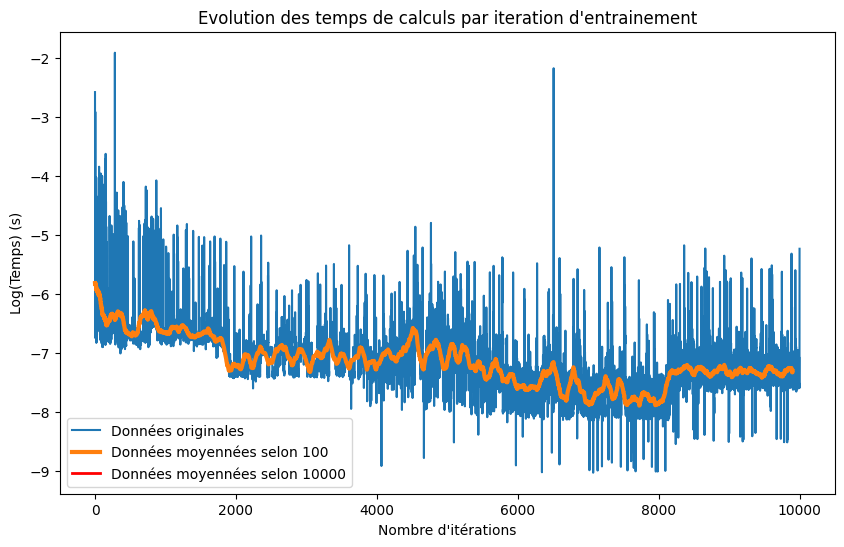

In [28]:
if __name__ == "__main__":

    path_trained_dataset = '/content/drive/My Drive/IA/IA Poker/flop_holdem_poker_stratModel_bis.json'
    trainer = FlopHoldemGame()
    trainer.train(path_dataset=path_trained_dataset, n_iterations=10000, clean_dataset=True)

    strategyModel = trainer.get_StrategyModel()
    with open(path_trained_dataset, 'w') as json_file:
        json.dump(strategyModel, json_file, indent=4)

    #Affichage
    trainer.get_trainingEvolution()
    #get_unitaryNodeMap(trainer.edges_list, trainer.playable_nodes)
    #print(trainer.get_StrategyModel)
    #display_results_detailed(i_map=trainer.get_nodeMap(), min_num_updates=1, focus_on="AcQc")
    #display_results_detailed_P1_fixed(i_map=trainer.get_nodeMap(), min_num_updates=10)

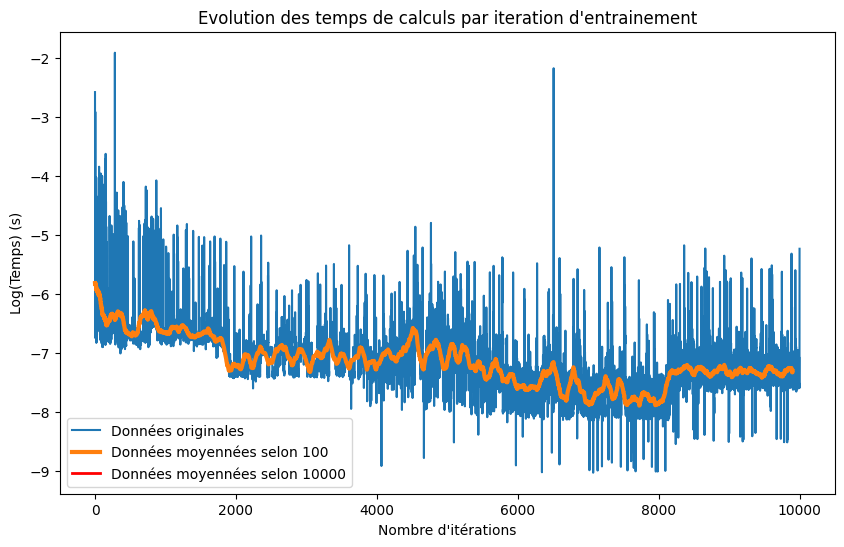

In [29]:
trainer.get_trainingEvolution()

Edge List : [('', 'p'), ('p', 'pp'), ('p', 'pb'), ('pb', 'pbp'), ('pb', 'pbb'), ('pbb', 'pbbr'), ('pbbr', 'pbbrp'), ('pbbrp', 'pbbrpp'), ('pbbrp', 'pbbrpb'), ('pbbrpb', 'pbbrpbp'), ('pbbrpb', 'pbbrpbb'), ('pbbr', 'pbbrb'), ('pbbrb', 'pbbrbp'), ('pbbrb', 'pbbrbb'), ('', 'b'), ('b', 'bp'), ('b', 'bb'), ('bb', 'bbr'), ('bbr', 'bbrp'), ('bbrp', 'bbrpp'), ('bbrp', 'bbrpb'), ('bbrpb', 'bbrpbp'), ('bbrpb', 'bbrpbb'), ('bbr', 'bbrb'), ('bbrb', 'bbrbp'), ('bbrb', 'bbrbb')]
Node Play-able List: ['', 'p', 'pb', 'pbbr', 'pbbrp', 'pbbrpb', 'pbbrb', 'b', 'bbr', 'bbrp', 'bbrpb', 'bbrb']


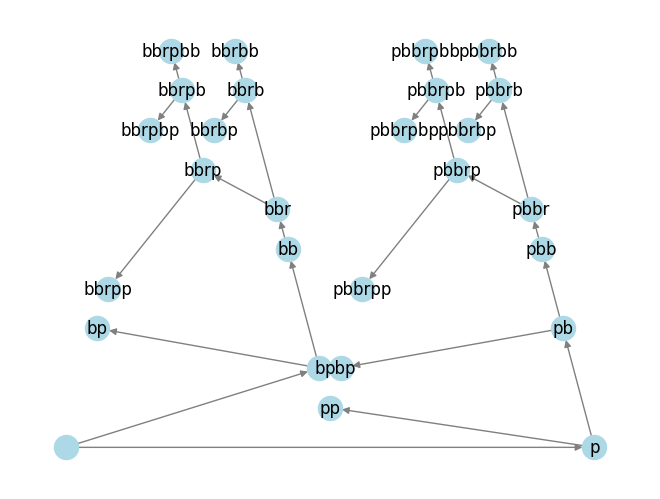

In [24]:
edges_list, playable_nodes = trainer.get_subgame()
get_unitaryNodeMap(edges_list, playable_nodes)

In [25]:
display_results_detailed(trainer.get_nodeMap())

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Key : QhJdAhKdKc bbr                 | Strategy : ['0.50', '0.50'] | Number of Updates : 1 | Average Reward : 0.375 | Is Converged : False
Key : QhJdAhKdKc bbrpb               | Strategy : ['0.50', '0.50'] | Number of Updates : 1 | Average Reward : -0.5 | Is Converged : False
Key : QhJdAhKdKc pbbr                | Strategy : ['0.00', '1.00'] | Number of Updates : 1 | Average Reward : 0.375 | Is Converged : False
Key : QhJdAhKdKc pbbrpb              | Strategy : ['0.00', '1.00'] | Number of Updates : 1 | Average Reward : -0.5 | Is Converged : False
Key : QhJdAsAhJh bbr                 | Strategy : ['1.00', '0.00'] | Number of Updates : 1 | Average Reward : -0.1875 | Is Converged : False
Key : QhJdAsAhJh bbrpb               | Strategy : ['1.00', '0.00'] | Number of Updates : 1 | Average Reward : -1.25 | Is Converged : False
Key : QhJdAsAhJh pbbr                | Strategy : ['1.00', '0.00'] | Number of Updates :

In [26]:
print(trainer.get_StrategyModel()) #To get the strategy dictionnary

{'Number of Played Games': 1000, 'Number of Theorical States': 1241080, 'Number of Visited States': 8732, 'Total Training Time': 6.147724151611328, 'Number of Converged States': 0, 'Is Game Converged': False, 'Kd': {'Qh': {'act': {'strat': {'val': [0.144, 0.856], 'nu': 6, 'nv': 3, 'nd': 2, 'ar': 0.54, 'arw': 0.505, 'arl': 0.339, 'cs': 0}, 'p': {'b': {'strat': {'val': [0.3065, 0.6935], 'nu': 6, 'nv': 3, 'nd': 2, 'ar': -0.768, 'arw': -1.137, 'arl': 0.021, 'cs': 0}}, 'strat': {'val': [0.0, 1.0], 'nu': 5, 'nv': 2, 'nd': 3, 'ar': 0.596, 'arw': -0.021, 'arl': 0.909, 'cs': 0}}, 'b': {'strat': {'val': [0.6248, 0.3752], 'nu': 5, 'nv': 2, 'nd': 3, 'ar': -0.864, 'arw': -0.208, 'arl': -1.14, 'cs': 0}}}, 'As': {'Ac': {'Jh': {'act': {'p': {'b': {'b': {'r': {'strat': {'val': [1.0, 0.0], 'nu': 1, 'nv': 0, 'nd': 1, 'ar': -0.188, 'arw': 0, 'arl': -0.188, 'cs': 0}, 'p': {'b': {'strat': {'val': [1.0, 0.0], 'nu': 1, 'nv': 0, 'nd': 1, 'ar': -1.25, 'arw': 0, 'arl': -1.25, 'cs': 0}}}}}}}, 'b': {'b': {'r': {'s

In [27]:
#1d3d bbrpb      ['0.79', '0.21']
best_strategy = botPoker("XhXdKdKcJc", "bbrp", trainer.get_StrategyModel())
print(best_strategy)

KeyError: 'strat'

# TAF

In [ ]:
#A faire

#Fonction d'activation
#Revoir fonction d'activation des regrets en Parametric ReLU à optimiser
#Faire IA pour estimer ce paramètre pour chaque node
#Enregistrer dataset entrainé pour Flop Holdem et valider

#Rhode Island Poker (One pocket card, 4 community cards, 3 betting rounds)
#Augmenter nombre de bet

#Royal Holdem Poker (Exaclty like Texas Holdem but the deck only contains cards 10 or higher)(First with single bet, then multiple choice of bet) (5 community cards, 4 bettings rounds) (2 pockets cards)
#Augmenter nombre de bet
#Adapter les common_cards pour ne considérer que la combinaison des 5 meilleurs cartes
#Passer à num_actions = 4 (actions = ['p', 'b', '2b', 'ai']
#Use Azure Cloud Server
#Texas Holdem Head's up


#Afficher nodeMap dans un nouvel onglet avec couleur playable_node et 'r' node



#Texas Holdem limit (6 players)
#Texas Holdem No Limit (6 players)
#See Deep CFR and ReBel

#1500 iterations to get Nash Equilibrium